This is a simple repository for time series prediction applied on the data of interest.
The basic idea is going to be illustrated by using a simple LSTM neural network to predict the energy consumption of one station (corresponding to one location)
This contains all the necessary steps from data preprocessing to the training loop

In [ ]:
# basic imports
import pandas as pd # pandas framework for preprocessing
import torch # PyTorch framework for automatic differentiation in Deep Learning
import torch.nn as nn # nn module from PyTorch: neural networks should inherit from the nn.Module Parent Class
import numpy as np # basic numpy 
import torch.optim as optim # the PyTorch module for stochastic gradient descent optimizers
import torch.utils.data as data # PyTorch module for creating datasets and dataloader
import matplotlib.pyplot as plt # simple plotting


#Data import

In [ ]:
# the main .csv file should be located in the sample_data folder if working on colab or the repo folder otherwise 
df = pd.read_csv('/content/sample_data/station_data_hour.csv') # import the data from the csv to a pandas Dataframe
df_subset = df.iloc[:2000] # keep the first 2000 rows (they correspond to the same station)
timeseries = df_subset[["energy_consumption"]].values.astype('float32') # keep the 'energy_consumption' column


#Simple visualization

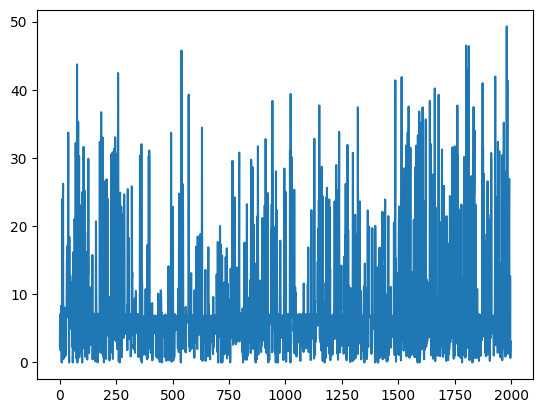

In [ ]:
plt.plot(timeseries)
plt.show()

# Create the dataset for PyTorch Model Training

In [ ]:
train_size_percentage = 0.7 # define the percentage of data that constitutes the training set (number between 0.6 and 0.9 typically)
train_size = int(len(timeseries) * train_size_percentage) # define the size of the training set
test_size = len(timeseries) - train_size # define the size of the test set
train, test = timeseries[:train_size], timeseries[train_size:] # split the data into training and test

In [ ]:
def create_dataset(dataset, lookback):
    '''
    function that takes the raw dataset and returns dataset consisting of features and labels
    Converts the dataset to PyTorch tensors
    Args:
    dataset -> the initial raw data from pandas
    lookback -> the time window for every new prediction (important hyperparameter)
    '''
    X, y = [], [] # create python lists for features and labels  
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback] # isolate the features
        target = dataset[i+1:i+lookback+1] # isolate the labels
        X.append(feature) # append to the feature list
        y.append(target) # append to the label list
    return torch.tensor(X), torch.tensor(y) # convert to PyTorch tensors and return 

In [ ]:
lookback = 1 # time window for prediction
X_train, y_train = create_dataset(train, lookback=lookback) # create the training dataset
X_test, y_test = create_dataset(test, lookback=lookback) # create the test dataset

# Typically in order to train a regressor in PyTorch one needs to create a dataset inheriting from the Dataset module
# and wrap it on a PyTorch Dataloader in order to iterate through batches
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8) # Dataloader

# Note: torch.tensor(np.array) is slow -> better use torch.from_numpy 

<ipython-input-9-7f277fbcf6c0>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X), torch.tensor(y) # convert to PyTorch tensors and return


# Create the Model (a simple LSTM)

In [ ]:
 
class LSTM_TimeSeries(nn.Module): # Should always inherit from nn.Module parent class
    def __init__(self):
        super().__init__() # class super constructor
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=3, batch_first=True) # lstm consisting of 3 layers
        self.linear = nn.Linear(50, 1) # final linear layer on top
    def forward(self, x): # forward pass in the neural network
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Training Loop

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # device (gpu or cpu)
model = LSTM_TimeSeries() # initialize the Model for training
model = model.to(device) # move the model in the device
optimizer = optim.Adam(model.parameters(), lr = 1e-4) # initialize the optimizer 
loss_fn = nn.MSELoss() # define the loss as the Mean Squared Error (Time Series Regression)


n_epochs = 2000 # number of epochs
for epoch in range(n_epochs): 
    model.train() # This is not a method that trains the model, it just puts the model into training mode (gradients can be computed)
    for X_batch, y_batch in loader: 
        X_batch = X_batch.to(device) # training features of the batch in the device
        y_batch = y_batch.to(device) # training labels of the batch in the device
        y_pred = model(X_batch) # pass the training features in the model and obtain the output
        loss = loss_fn(y_pred, y_batch) # compute the loss
        optimizer.zero_grad() # zero the gradients 
        loss.backward() # compute the gradients
        optimizer.step() # update network's parameters
    # Validation
    if epoch % 2 != 0: 
        continue
    model.eval()
    with torch.no_grad():
      # evaluate every # of training steps
        X_train = X_train.to(device)
        y_pred = model(X_train)
        train_rmse = (loss_fn(y_pred, y_train))
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_test = y_test.to(device)
        test_rmse = (loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))